# Topic Creation from Tweets

Many thanks to Brandon Rose and Rik Nijessen whose online [tutorial](http://brandonrose.org/clustering) and [report](https://towardsdatascience.com/automatic-topic-clustering-using-doc2vec-e1cea88449c), respectively, helped provide much of this code. 

## Initial Set-up

In [2]:
import numpy as np
import pandas as pd
import nltk
import re
import os
import codecs
from sklearn import feature_extraction
import mpld3
import json
from HTMLParser import HTMLParser
import matplotlib.pyplot as plt; plt.rcdefaults()
import numpy as np
import matplotlib.pyplot as plt
import logging
from gensim.models.doc2vec import TaggedDocument, Doc2Vec
from nltk.tokenize import RegexpTokenizer
from nltk.stem.porter import PorterStemmer
import gensim
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from __future__ import print_function
from collections import Counter
from nltk.stem.snowball import SnowballStemmer
import string
from nltk.tag import pos_tag
from gensim import corpora, models, similarities 
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.externals import joblib

Aggregate tweets from 2015-2017 and the speeches said by Donald Trump in 2016 into a single dataframe. The column "format" signals whether or not the text is a tweet or from a speech, which will be necessary in the tweet generation portion of this project.

In [38]:
h = HTMLParser()

json_data=open('condensed_2015.json').read()
json_data = h.unescape(json_data)
json_data = json_data.decode('utf-8')
all_dat_15 = pd.read_json(json_data)
all_dat_15['format'] = 0

json_data=open('condensed_2016.json').read()
json_data = h.unescape(json_data)
json_data = json_data.decode('utf-8')
all_dat_16 = pd.read_json(json_data)
all_dat_16['format'] = 0

json_data=open('condensed_2017.json').read()
json_data = h.unescape(json_data)
json_data = json_data.decode('utf-8')
all_dat_17 = pd.read_json(json_data)
all_dat_17['format'] = 0

speeches = pd.read_table('speeches.txt', header=None, encoding = 'utf8')
speeches.columns = ['text']
speeches['format_'] = 1

In [39]:
frames = [all_dat_17, all_dat_16, all_dat_15]
all_dat = pd.concat(frames)
all_dat = all_dat.reset_index(drop=True)

In [40]:
format_ = list(all_dat.format)

# Doc2Vec

Doc2Vec is an extension of the Word2Vec model with an additional vector representing documents. We begin by cleaning up the data -- in this case remove stopwords, links, and make all text lowercase.

In [44]:
#stopwords = stopwords.words('english')
all_dat_doc2vec = all_dat.copy()
all_dat_doc2vec['text'] = [re.sub(r"http\S+", "", all_dat['text'][i]) for i in range(0, len(all_dat))]
all_dat_doc2vec['text'] = all_dat_doc2vec['text'].apply(lambda x: [item for item in x.split() if item.lower() not in stopwords])
all_dat_doc2vec['text'] = [" ".join(all_dat_doc2vec['text'][i]).lower() for i in range(0, len(all_dat_doc2vec))]
texts = all_dat_doc2vec['text'].tolist()
format_ = list(all_dat_doc2vec.format)

Change the synopses into a format readable by the Doc2Vec model, in this case, TaggedDocument elements.

In [45]:
class Documents(object):
    def __init__(self, documents):
        self.documents = documents

    def __iter__(self):
        for i, doc in enumerate(self.documents):
            yield TaggedDocument(words = doc, tags = [i])

In [8]:
documents = Documents(texts)

In [9]:
model = Doc2Vec(size=100, dbow_words= 1, dm=0, iter=1,  window=5, seed=42, min_count=5, workers=40,alpha=0.025, min_alpha=0.025)

In [10]:
model.build_vocab(documents)

In [31]:
count = len(all_dat)
for epoch in range(50):
    if epoch%10 == 0:
        print("epoch "+str(epoch))
    model.train(documents, total_examples=count, epochs=1)
    model.save('tweet-dataset.model')
    if epoch%10 == 0:
        model.alpha -= 0.002  # decrease the learning rate
        model.min_alpha = model.alpha  # fix the learning rate, no decay

epoch 0
epoch 10
epoch 20
epoch 30
epoch 40


In [36]:
fname = "tweet-dataset.model"
model = Doc2Vec.load(fname)

Translate each of the synopses into the vectors formed by the Doc2Vec model.

In [46]:
vectors = []
print("inferring vectors")
duplicate_dict = {}
used_lines = []
for i, t in enumerate(texts):
    duplicate_dict[t] = True
    used_lines.append(t)
    vectors.append(model.infer_vector(t))

print("done")

inferring vectors
done


Cluster the Doc2Vec vectors

In [14]:
num_clusters = 15
km = KMeans(n_jobs=-1, n_clusters=num_clusters, random_state = 42)

%time km.fit(vectors)
clusters = km.labels_.tolist()

CPU times: user 380 ms, sys: 286 ms, total: 666 ms
Wall time: 4.18 s


In [15]:
all_texts = {'text': texts,  'cluster': clusters, 'format_':format_}

frame = pd.DataFrame(all_texts, index = [clusters] , columns = ['text', 'cluster', 'format_'])

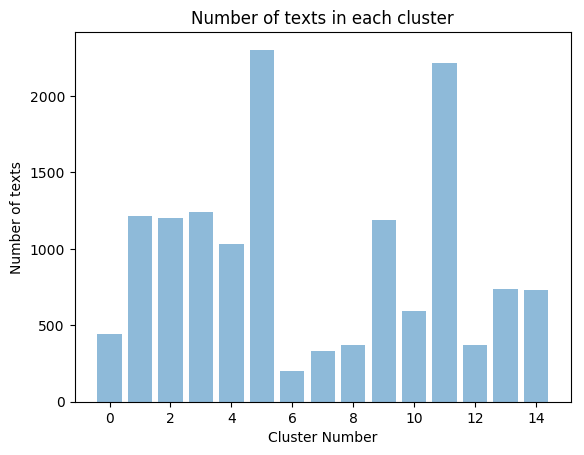

In [16]:
plt.bar(range(0,15), [frame['cluster'].value_counts()[i] for i in range(0, 15)], align='center', alpha=0.5)
plt.ylabel('Number of texts')
plt.xlabel('Cluster Number')
plt.title('Number of texts in each cluster')
plt.show()

In [17]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

for i in range(0, 15):
    titles = frame[frame['cluster']==i]
    words = [x for x in titles['text']]
    count = Counter(' '.join(words))
    count = Counter(' '.join(words).split(' '))
    s = ''
    print('Cluster '+str(i)+' words:')

    for i in  count.most_common()[:20]:
        s += i[0]+" "
    print(s+'\n')

Top terms per cluster:

Cluster 0 words:
rt & thank great @realdonaldtrump american - make join america going honor new get president trump w/ today us time 

Cluster 1 words:
#trump2016 @realdonaldtrump thank #makeamericagreatagain #trump2016" trump great & 2016 you! new america join vote get president need - donald make 

Cluster 2 words:
- great & thank -- hillary trump new @realdonaldtrump big people get make like crooked many america don't one going 

Cluster 3 words:
& great thank people hillary @realdonaldtrump trump big make get would america new many never - like good much one 

Cluster 4 words:
@realdonaldtrump @foxnews great trump & @foxandfriends tax next president rt thank would - big fox donald america fix u.s. mexico 

Cluster 5 words:
@realdonaldtrump trump great thank donald america make would #makeamericagreatagain love president you! people rt like new run need & don't 

Cluster 6 words:
@realdonaldtrump great rt & #usa🇺🇸 thank 🇺🇸 #maga🇺🇸 🎥 president women america tr

# Term Frequency-Inverse Document Frequency

A word's TF-IDF for a specific text increases as the word appears more in the text, but then decreases if the word appears many times in the overall set of texts. We begin by preparing the texts for the TF-IDF vectorizer by removing stopwords and identifying stems and tokens of words in the texts.

In [18]:
stemmer = SnowballStemmer("english")

In [19]:
def tokenize_and_stem(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    stems = [stemmer.stem(t) for t in filtered_tokens]
    return stems

def tokenize_only(text):
    # first tokenize by sentence, then by word to ensure that punctuation is caught as it's own token
    tokens = [word.lower() for sent in nltk.sent_tokenize(text) for word in nltk.word_tokenize(sent)]
    filtered_tokens = []
    # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
    for token in tokens:
        if re.search('[a-zA-Z]', token):
            filtered_tokens.append(token)
    return filtered_tokens

In [21]:
nltk.download('punkt')
texts = all_dat['text'].tolist()
totalvocab_stemmed = []
totalvocab_tokenized = []
for i in texts:
    allwords_stemmed = tokenize_and_stem(i)
    totalvocab_stemmed.extend(allwords_stemmed)
    
    allwords_tokenized = tokenize_only(i)
    totalvocab_tokenized.extend(allwords_tokenized)

[nltk_data] Downloading package punkt to /Users/Melissa/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [22]:
vocab_frame = pd.DataFrame({'words': totalvocab_tokenized}, index = totalvocab_stemmed)
print ('there are ' + str(vocab_frame.shape[0]) + ' items in vocab_frame')

there are 249018 items in vocab_frame


Create the TF-IDF model of our texts.

In [23]:
tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=200000,
                                 min_df=10, stop_words='english',
                                 use_idf=True, tokenizer=tokenize_and_stem, ngram_range=(1,3))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(texts)

print(tfidf_matrix.shape)

CPU times: user 15.9 s, sys: 249 ms, total: 16.2 s
Wall time: 16.7 s
(14173, 2639)


Cluster features according to their TF-IDF vectors.

In [24]:
terms = tfidf_vectorizer.get_feature_names()
dist = 1 - cosine_similarity(tfidf_matrix)

In [25]:
num_clusters = 15
km = KMeans(n_jobs=-1, n_clusters=num_clusters, random_state = 42)
%time km.fit(tfidf_matrix)
clusters = km.labels_.tolist()

CPU times: user 226 ms, sys: 446 ms, total: 673 ms
Wall time: 49.2 s


In [26]:
all_texts = {'text': texts,  'cluster': clusters, 'format_':format_}

frame = pd.DataFrame(all_texts, index = [clusters] , columns = ['text', 'cluster', 'format_'])

In [27]:
frames = [frame, speeches]
pd.concat(frames).reset_index(drop=True).to_csv('clustered_texts.csv', encoding='utf-8')

In [28]:
print("Top terms per cluster:")
print()
order_centroids = km.cluster_centers_.argsort()[:, ::-1]

F = open('topics.txt','w') 
for i in range(num_clusters):
    F.write('Cluster '+str(i)+' words:')
    print('Cluster '+str(i)+' words:')
    s = ""
    for ind in order_centroids[i, :40]:
        F.write(' '+str(vocab_frame.loc[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore')))
        s+=str(vocab_frame.ix[terms[ind].split(' ')].values.tolist()[0][0].encode('utf-8', 'ignore'))+' '
    F.write('\n')
    print(s)
    print( )
F.close()

Top terms per cluster:

Cluster 0 words:

/Users/Melissa/anaconda/envs/py27/lib/python2.7/site-packages/ipykernel/__main__.py:12: DeprecationWarning: 
.ix is deprecated. Please use
.loc for label based indexing or
.iloc for positional indexing

See the documentation here:
http://pandas.pydata.org/pandas-docs/stable/indexing.html#ix-indexer-is-deprecated



https people 's just n't time rt like totally bad country jobs american many new today failing looking want years obama thank news say said did president reporters u.s. only watch media states debate work entrepreneurs vote polls why cruz 

Cluster 1 words:
ca ca n't n't ca wait realdonaldtrump realdonaldtrump realdonaldtrump trump watch 's think great winning just country bought ca vote n't cnn n't say ca president n't wait stand till believe want celebapprentice things just just ted right people making 

Cluster 2 words:
enjoy interview tonight foxandfriends a.m. morning foxnews seanhannity interview p.m. morning a.m. oreillyfactor oreillyfactor enjoy a.m p.m. fox tomorrow interview foxandfriends foxnews talking cnn interview seanhannity interview https interview morning_joe tomorrow tonight interview greta minutes abc foxbusiness et tonight realdonaldtrump 

Cluster 3 words:
donald donald trump http https president realdonaldtrump donald 's trump polls donald thank realdonaldtrump 

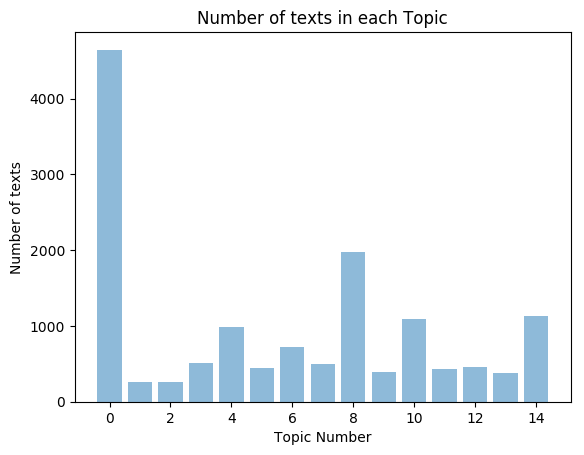

In [29]:
plt.bar(range(0,15), [frame['cluster'].value_counts()[i] for i in range(0, 15)], align='center', alpha=0.5)
plt.ylabel('Number of texts')
plt.xlabel('Topic Number')
plt.title('Number of texts in each Topic')
plt.show()

# Latent Dirichlet Allocation

LDA views each text as a mixture of topics and each topic as a mixture of words, all of which can be overlapping. 

In [30]:
%time tokenized_text = [tokenize_and_stem(text) for text in texts]
%time texts = [[word for word in text if word not in stopwords] for text in tokenized_text]

CPU times: user 15 s, sys: 491 ms, total: 15.5 s
Wall time: 18.3 s
CPU times: user 854 ms, sys: 47 ms, total: 901 ms
Wall time: 1.13 s


In [19]:
dictionary = corpora.Dictionary(texts)
dictionary.filter_extremes(no_below=5, no_above=0.8)
corpus = [dictionary.doc2bow(text) for text in texts]
%time lda = models.LdaMulticore(corpus, num_topics=15, workers=40, id2word=dictionary, chunksize=10000, passes=100)

CPU times: user 22min 48s, sys: 1min 55s, total: 24min 43s
Wall time: 24min 20s


In [21]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
for i in range(0,len(topics_matrix)):
    print("topic "+str(i)+": ")
    for k in range(0,20):
        print(topics_matrix[i][1][k])
    print('\n')

topic 0: 
(u'trump', 0.11519502269440726)
(u'poll', 0.067023670244187955)
(u'donald', 0.056155496119191246)
(u'via', 0.048582810748328903)
(u'lead', 0.02113593972148722)
(u'rubio', 0.019744334240026314)
(u'gop', 0.017853098606439272)
(u'new', 0.015493229825747029)
(u'cruz', 0.012548300960387419)
(u'debat', 0.011199077593444809)
(u'bush', 0.010590314817161895)
(u'marco', 0.01025592270006823)
(u'foxnew', 0.0094568295219296453)
(u'number', 0.0092768322127983176)
(u'carson', 0.0089019571579296436)
(u'win', 0.0087877071755171465)
(u"'s", 0.0086240494173545745)
(u'nation', 0.0081363108619029144)
(u'jeb', 0.0078002800359367429)
(u'show', 0.005968154505741903)


topic 1: 
(u'interview', 0.042585039788602584)
(u'last', 0.038006002572248447)
(u'great', 0.033904221581877253)
(u'night', 0.033291508964949139)
(u'tonight', 0.033177371968823283)
(u'foxnew', 0.030954248192883685)
(u'enjoy', 0.030758431216146336)
(u'foxandfriend', 0.018103915770304336)
(u'morn', 0.016487553292276028)
(u'watch', 0.01513

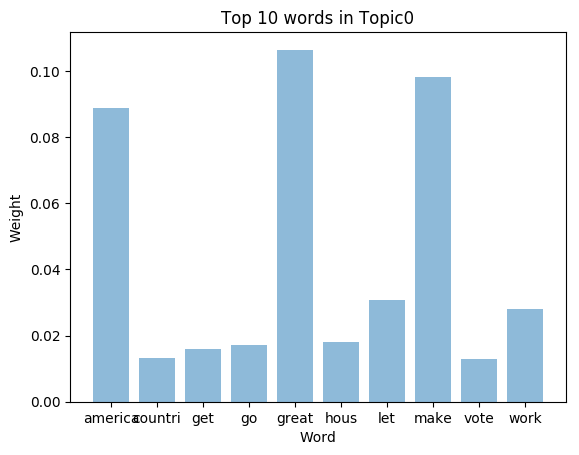

[u'great', u'make', u'america', u'let', u'work', u'hous', u'go', u'get', u'countri', u'vote']


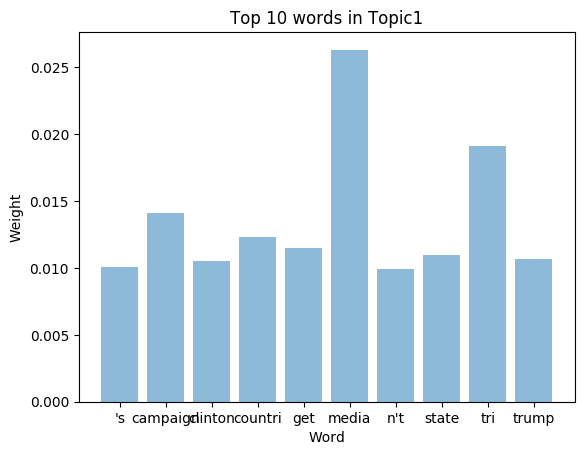

[u'media', u'tri', u'campaign', u'countri', u'get', u'state', u'trump', u'clinton', u"'s", u"n't"]


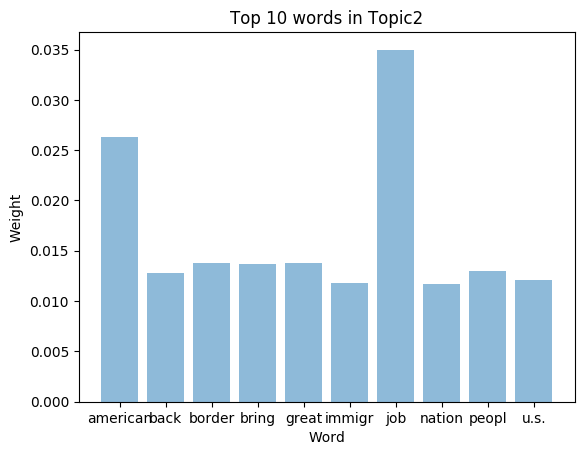

[u'job', u'american', u'border', u'great', u'bring', u'peopl', u'back', u'u.s.', u'immigr', u'nation']


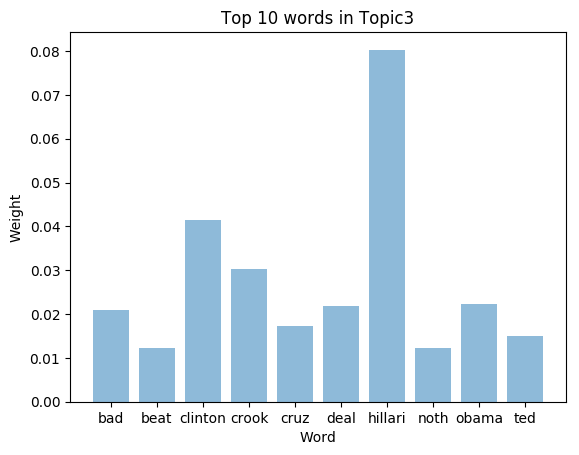

[u'hillari', u'clinton', u'crook', u'obama', u'deal', u'bad', u'cruz', u'ted', u'noth', u'beat']


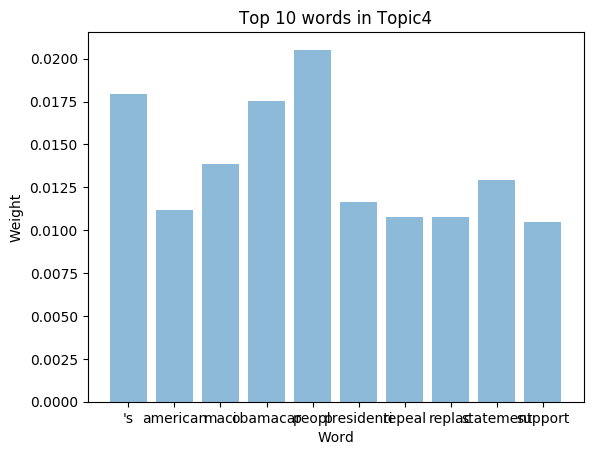

[u'peopl', u"'s", u'obamacar', u'maci', u'statement', u'presidenti', u'american', u'replac', u'repeal', u'support']


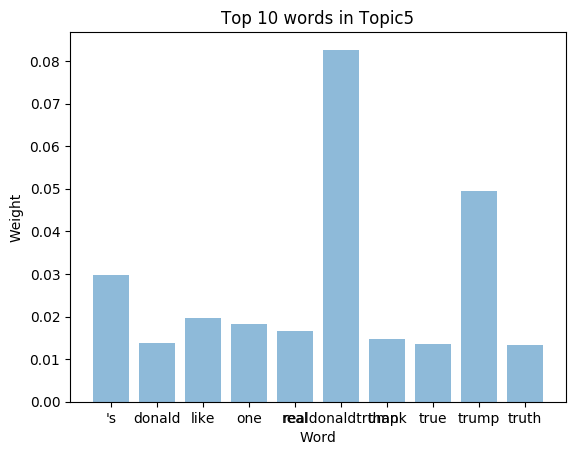

[u'realdonaldtrump', u'trump', u"'s", u'like', u'one', u'real', u'thank', u'donald', u'true', u'truth']


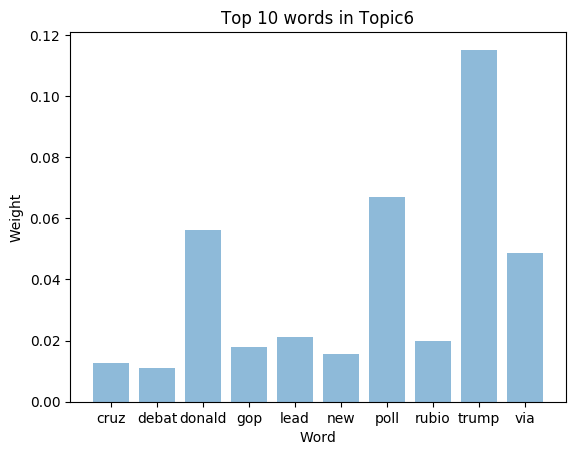

[u'trump', u'poll', u'donald', u'via', u'lead', u'rubio', u'gop', u'new', u'cruz', u'debat']


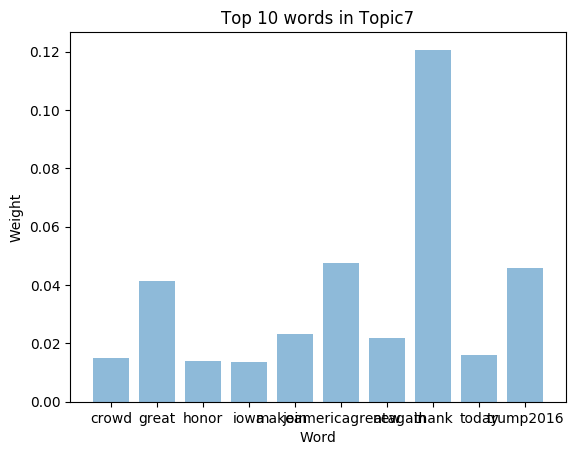

[u'thank', u'makeamericagreatagain', u'trump2016', u'great', u'join', u'new', u'today', u'crowd', u'honor', u'iowa']


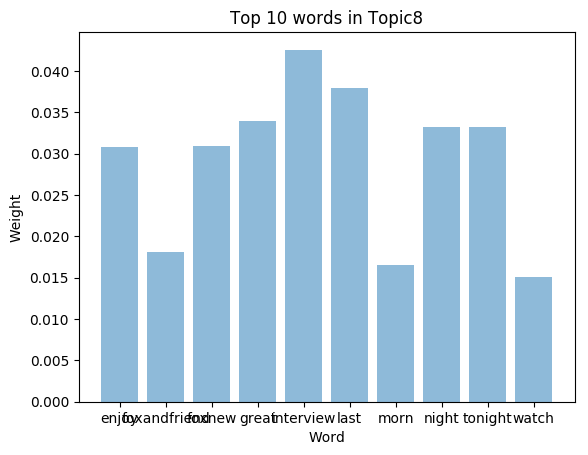

[u'interview', u'last', u'great', u'night', u'tonight', u'foxnew', u'enjoy', u'foxandfriend', u'morn', u'watch']


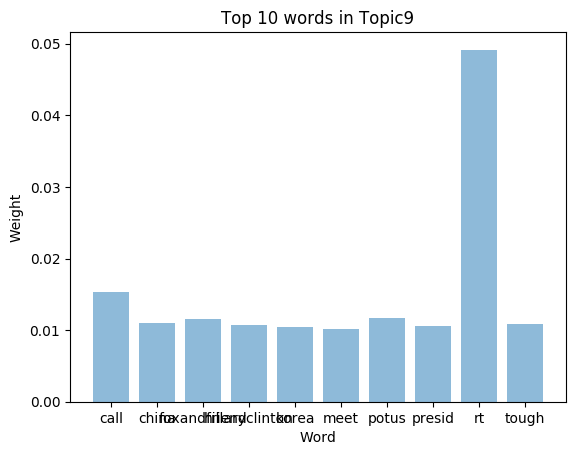

[u'rt', u'call', u'potus', u'foxandfriend', u'china', u'tough', u'hillaryclinton', u'presid', u'korea', u'meet']


In [31]:
topics_matrix = lda.show_topics(formatted=False, num_words=20)
for i in range(0,len(topics_matrix)):
    words = []
    values = []
    for k in range(0,10):
        words.append(topics_matrix[i][1][k][0])
        values.append(topics_matrix[i][1][k][1])
    plt.bar(words, values, alpha=0.5)
    plt.ylabel('Weight')
    plt.xlabel('Word')
    plt.title('Top 10 words in Topic'+str(i))
    plt.show()
    print(words)